In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import konlpy
from konlpy.tag import Okt
from keras.layers import Embedding, Dense, LSTM, Activation
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

Using TensorFlow backend.


In [2]:
df = pd.read_excel("test_all2.xlsx")

In [3]:
df.head()

,content,countryEnName,countryName,fileUrl,id,title,wrtDt,Div
0,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",United States of America,미국,NaN,ATC0000000007885,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,2020-05-27,정보
1,홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,hongkong,홍콩(중국),NaN,ATC0000000007884,홍콩 시위 관련 안전공지(5.26),2020-05-26,치안
2,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,Australia,호주,NaN,ATC0000000007881,호주 열대성 폭풍 Manga 관련 안전 공지,2020-05-23,자연재해
3,태국 뎅기열 유행에 따른 유의사항 안내&nbsp;○ 최근 태국 동북부 지역에서 뎅기...,Thailand,태국,NaN,ATC0000000007857,태국 뎅기열 유행에 따른 유의사항,2020-05-19,질병
4,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,Hungary,헝가리,http://www.0404.go.kr/dev/fileDownload.mofa?at...,ATC0000000007855,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,2020-05-19,정보


In [4]:
len(df)

5574

In [5]:
df = df.loc[pd.isnull(df['Div'])]
print(len(df))

2174


In [6]:
df['Content'] = df.apply(lambda x: np.nan if pd.isnull(x['title']) and pd.isnull(x['content']) else x['title'] if pd.isnull(x['content']) else x['title'] + ' ' + x['content'] , axis=1)

In [7]:
df = df[['Content']]

In [8]:
df.head()

,Content
42,"페루 정부, 긴급명령 발표 (국경폐쇄 및 의무격리) 페루 정부, 긴급명령 발표 (국..."
56,마다가스카르 입국 제한 조치 발표 마다가스카르 입국 제한 조치 발표1. 마다가스카르...
61,마셜제도 입국 제한 조치 발표 마셜제도 입국 제한 조치 발표(마셜제도)1. 태평양 ...
62,바누아투 입국 제한 조치 발표 바누아투 입국 제한 조치 발표(바누아투)1. 태평양 ...
435,홍콩국제공항 시위 관련 안전공지 홍콩국제공항 시위 관련 안전공지&nbsp;​﻿ㅇ&n...


In [9]:
from konlpy.tag import Okt

stopwords = ['콜센터', '등', '및', '번호', '전', '하다', '하여', '월', '화', '수', '목', '금', '토', '일']

X = []
okt = Okt()

for i in range(len(df)):
    _x = df.iloc[i]['Content']
    
    okt_morphs = okt.pos(_x)  # 튜플반환
    temp_x = []
    for word, pos in okt_morphs:
        if pos == 'Noun' or pos == 'Verb':
            temp_x.append(word)
            
    temp_x = [word for word in temp_x if not word in stopwords]
    X.append(temp_x)
    

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

제목의 최대 길이 :  1023
제목의 평균 길이 :  114.09429622815087


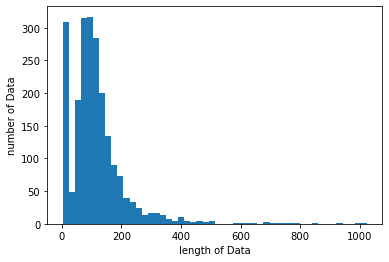

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

print("제목의 최대 길이 : ", max(len(l) for l in X))
print("제목의 평균 길이 : ", sum(map(len, X))/ len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [13]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

max_len = max(len(l) for l in X) # 전체 데이터의 길이를 20로 맞춘다
max_len = 1728
X = pad_sequences(X, maxlen=max_len)

In [14]:
# loading model
from keras.models import model_from_json

model = model_from_json(open('model_architecture.json').read())
model.load_weights('model_weights.h5')

# dont forget to compile your model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 204       
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
Total params: 3,550,604
Trainable params: 3,550,604
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_pred = model.predict_classes(X, verbose=1)

2174/2174 [==============================] - 31s 14ms/step


In [29]:
y_pred

array([3, 3, 3, ..., 3, 1, 3], dtype=int64)

In [30]:
len(y_pred)

2174

In [23]:
# row_maxes = y_pred.argmax(axis=1)

In [24]:
# row_maxes

array([3, 3, 3, ..., 3, 1, 3], dtype=int64)

In [31]:
dic = {
    0: '정보',
    1: '자연재해',
    2: '질병',
    3: '치안'
}
l = []
for i in range(len(y_pred)):
    l.append(dic[y_pred[i]])
l

['치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '질병',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '정보',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '질병',
 '치안',
 '질병',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',

In [32]:
df = pd.read_excel("test_all2.xlsx")
df = df.loc[pd.isnull(df['Div'])]
# div_df = pd.DataFrame(l, columns =['Div'])
df['Div'] = l

In [33]:
df.to_excel("result.xlsx", index=False)

In [38]:
# 다층 LSTM을 구현하기 위한 함수
def stacked_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 100))
    model.add(LSTM(50, return_sequences = True))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

# model = KerasClassifier(build_fn = stacked_lstm, epochs = 200, batch_size = 50, verbose = 1)
model = KerasClassifier(build_fn = stacked_lstm, epochs = 10, batch_size = 10, verbose = 1, validation_split=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_test_ = np.argmax(y_test, axis = 1)
print(accuracy_score(y_pred, y_test_))

C:\Users\min-sung.lee\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2448 samples, validate on 272 samples
Epoch 1/10
2448/2448 [==============================] - 407s 166ms/step - loss: 0.5773 - accuracy: 0.7953 - val_loss: 0.3317 - val_accuracy: 0.9118
Epoch 2/10
2448/2448 [==============================] - 385s 157ms/step - loss: 0.2091 - accuracy: 0.9375 - val_loss: 0.2042 - val_accuracy: 0.9301
Epoch 3/10
2448/2448 [==============================] - 384s 157ms/step - loss: 0.1199 - accuracy: 0.9628 - val_loss: 0.1672 - val_accuracy: 0.9522
Epoch 4/10
2448/2448 [==============================] - 388s 159ms/step - loss: 0.0897 - accuracy: 0.9714 - val_loss: 0.1692 - val_accuracy: 0.9412
Epoch 5/10
2448/2448 [==============================] - 401s 164ms/step - loss: 0.4162 - accuracy: 0.8623 - val_loss: 0.2065 - val_accuracy: 0.9485
Epoch 6/10
2448/2448 [==============================] - 382s 156ms/step - loss: 0.1031 - accuracy: 0.9698 - val_loss: 0.1672 - val_accuracy: 0.9559
Epoch 7/10
2448/2448 [==============================] - 379s 155m

In [39]:
import pickle

with open('model1.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

In [40]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

AttributeError: 'KerasClassifier' object has no attribute 'history'

In [48]:
print("Accuracy: {:.4f}%".format(model.evaluate(x_test,y_test)[1]*100))

24/24 [==============================] - 0s 5ms/step
Accuracy: 75.0000%


In [44]:
predict = model.predict(x_test)

predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

In [46]:

for i in range(20): 
    print("기사제목 : ", x_test['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])

기사제목 :  미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  홍콩 시위 관련 안전공지(5.26) /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  호주 열대성 폭풍 Manga 관련 안전 공지 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  태국 뎅기열 유행에 따른 유의사항 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  ‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 /	 원래 라벨 :  1 /	예측한 라벨 :  2
기사제목 :  ‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  ‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 /	 원래 라벨 :  2 /	예측한 라벨 :  2
기사제목 :  ‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  헝가리 예외적 입국허가(입국 규제 면제 요청) 관련 안내 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  헝가리 예외적 입국허가(입국 규제 면제 요청) 관련 안내 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  헝가리 예외적 입국허가(입국 규제 면제 요청) 관련 안내 /	 원래 라벨 :  2 /	예측한 라벨 :  2
기사제목 :  사이클론 암판 상륙(인도, 방글라데시) 관련 안전유의 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  러시아 극동지역 야생진드기 관련 안내 사항 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  파푸아뉴기니 군·경간 충돌사태 발생 관련 안전 유의 /	 원래 라벨 :  3 /	예측한 라벨 :  3
기사제목 :  덴마크 테러 관련 안전 공지 /	 원래 라벨 :  2 /	예측한 라벨 :  3
기사제목 :  포르투갈 해외송금 사기피해 안전유의 /	 원래 라벨 :  3 /	예측한

In [12]:
train, test = train_test_split(df, test_size=0.2)

In [56]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ModuleNotFoundError: No module named 'sklearn'

In [20]:
Okt = Okt()
Okt_morphs = Okt.pos(t)  # 튜플반환
print(Okt_morphs)

[('&', 'Punctuation'), ('nbsp', 'Alpha'), (';&', 'Punctuation'), ('nbsp', 'Alpha'), (';', 'Punctuation'), ('미국', 'Noun'), (',', 'Punctuation'), ('입국', 'Noun'), ('전', 'Noun'), ('14일', 'Number'), ('이상', 'Noun'), ('브라질', 'Noun'), ('체류', 'Noun'), ('한', 'Josa'), ('모든', 'Noun'), ('외국인', 'Noun'), ('입국', 'Noun'), ('규제', 'Noun'), ('관련', 'Noun'), ('안내', 'Noun'), ('&', 'Punctuation'), ('nbsp', 'Alpha'), (';&', 'Punctuation'), ('nbsp', 'Alpha'), (';&', 'Punctuation'), ('nbsp', 'Alpha'), (';', 'Punctuation'), ('○', 'Foreign'), ('미국', 'Noun'), ('정부', 'Noun'), ('는', 'Josa'), ('2020년', 'Number'), ('5월', 'Number'), ('24일', 'Number'), ('대통령', 'Noun'), ('선포', 'Noun'), ('에', 'Josa'), ('이어', 'Verb'), ('25일', 'Number'), ('수', 'Modifier'), ('정안', 'Noun'), ('을', 'Josa'), ('발표', 'Noun'), (',', 'Punctuation'), ('미국', 'Noun'), ('입국', 'Noun'), ('전', 'Noun'), ('브라질', 'Noun'), ('에서', 'Josa'), ('14일', 'Number'), ('이상', 'Noun'), ('체류', 'Noun'), ('한', 'Josa'), ('모든', 'Noun'), ('외국인', 'Noun'), ('에', 'Josa'), ('대한', 'No

In [34]:
Noun_words = []
for word, pos in Okt_morphs:
#     if pos == 'Noun' or pos == 'Verb':
    if pos == 'Noun':
        Noun_words.append(word)
print(Noun_words)

['미국', '입국', '전', '이상', '브라질', '체류', '모든', '외국인', '입국', '규제', '관련', '안내', '미국', '정부', '대통령', '선포', '정안', '발표', '미국', '입국', '전', '브라질', '이상', '체류', '모든', '외국인', '대한', '입국', '규제', '조치', '동부', '일광', '절약', '시간', '부터', '적용', '발표', '미국인', '및', '그', '배우자', '승무원', '및', '미국', '정부', '초청', '사람', '등', '제외', '브라질', '수', '기준', '코로나', '확', '진자', '수', '명', '세계', '위', '위', '미국', '다만', '화', '이전', '출발', '미국', '도착', '항공', '편', '해당', '조치', '적용', '이', '관련', '브라질', '경유', '미국', '방문', '계획', '분', '관련', '사항', '숙지', '상황', '발생', '유의', '기타', '각종', '도움', '분', '아래', '연락처', '참고', '도움', '콜센터', '미국', '대한민국', '대사관', '대표', '일반', '번호', '긴급', '번호']


In [35]:
stopwords = ['콜센터', '등', '및', '번호', '전', '하다', '하여', '월', '화', '수', '목', '금', '토', '일']
unique_Noun_words = set(Noun_words)
for word in unique_Noun_words:
    if word in stopwords:
        while word in Noun_words: Noun_words.remove(word)

In [36]:
print(Noun_words)

['미국', '입국', '이상', '브라질', '체류', '모든', '외국인', '입국', '규제', '관련', '안내', '미국', '정부', '대통령', '선포', '정안', '발표', '미국', '입국', '브라질', '이상', '체류', '모든', '외국인', '대한', '입국', '규제', '조치', '동부', '일광', '절약', '시간', '부터', '적용', '발표', '미국인', '그', '배우자', '승무원', '미국', '정부', '초청', '사람', '제외', '브라질', '기준', '코로나', '확', '진자', '명', '세계', '위', '위', '미국', '다만', '이전', '출발', '미국', '도착', '항공', '편', '해당', '조치', '적용', '이', '관련', '브라질', '경유', '미국', '방문', '계획', '분', '관련', '사항', '숙지', '상황', '발생', '유의', '기타', '각종', '도움', '분', '아래', '연락처', '참고', '도움', '미국', '대한민국', '대사관', '대표', '일반', '긴급']


In [37]:
from collections import Counter
c = Counter(Noun_words)
print(c.most_common(10))

[('미국', 8), ('입국', 4), ('브라질', 4), ('관련', 3), ('이상', 2), ('체류', 2), ('모든', 2), ('외국인', 2), ('규제', 2), ('정부', 2)]


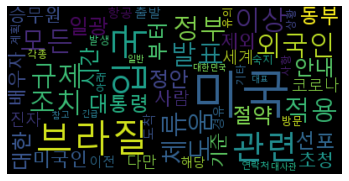

In [38]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

noun_text = ''
for word in Noun_words:
    noun_text = noun_text +' '+word

wordcloud = WordCloud(max_font_size=60, relative_scaling=.5, font_path=FONT_PATH).generate(noun_text) # generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [31]:
X_train = [Noun_words]

In [32]:
from keras.preprocessing.text import Tokenizer
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [33]:
X_train

[[1,
  2,
  6,
  7,
  3,
  8,
  9,
  10,
  2,
  11,
  4,
  20,
  1,
  12,
  21,
  22,
  23,
  24,
  13,
  1,
  2,
  6,
  3,
  7,
  8,
  9,
  10,
  25,
  2,
  11,
  14,
  26,
  27,
  28,
  29,
  30,
  15,
  31,
  13,
  32,
  33,
  34,
  35,
  36,
  1,
  12,
  37,
  38,
  39,
  40,
  41,
  3,
  16,
  42,
  43,
  44,
  45,
  16,
  46,
  47,
  17,
  17,
  1,
  48,
  49,
  50,
  51,
  1,
  52,
  53,
  54,
  55,
  14,
  15,
  56,
  57,
  58,
  4,
  3,
  59,
  5,
  1,
  60,
  61,
  62,
  18,
  4,
  63,
  64,
  5,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  19,
  18,
  74,
  75,
  76,
  5,
  19,
  77,
  78,
  1,
  79,
  80,
  81,
  82,
  83]]

In [ ]:
print("제목의 최대 길이 : ", max(len(l) for l in X_train))
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()



In [ ]:
import numpy as np
y_train = []
y_test = []
for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i] == 1:
        y_train.append([0, 0, 1])
    elif train_data['label'].iloc[i] == 0:
        y_train.append([0, 1, 0]) 
    elif train_data['label'].iloc[i] == -1:
        y_train.append([1, 0, 0])
        
for i in range(len(test_data['label'])):
    if test_data['label'].iloc[i] == 1:
        y_test.append([0, 0, 1])
    elif test_data['label'].iloc[i] == 0:
        y_test.append([0, 1, 0])
    elif test_data['label'].iloc[i] == -1:
        y_test.append([1, 0, 0])

        
y_train = np.array(y_train)
y_test = np.array(y_test)



In [ ]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
max_len = 20 # 전체 데이터의 길이를 20로 맞춘다
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [ ]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))
# optimizer rmsprop
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)


In [ ]:
print("Accuracy: {:.2f}%".format(model.evaluate(X.test,y_test)[1]*100))

In [ ]:
predict = model.predict(X_test)

predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)



In [ ]:
for i in range(30): 
    print("기사제목 : ", test_data['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


In [15]:
import lxml.html
import lxml.html.clean

doc = lxml.html.fromstring(t)
cleaner = lxml.html.clean.Cleaner(style=True)
doc = cleaner.clean_html(doc)
text = doc.text_content()
text

'\xa0\xa0미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내\xa0\xa0\xa0○ 미국 정부는 2020년 5월 24일 대통령 선포에 이어 25일 수정안을 발표, 미국 입국 전 브라질에서 14일 이상 체류한 모든 외국인에 대한 입국 규제 조치를 2020년 5월 26일 동부 일광 절약 시간으로 23:59부터 적용된다고 발표하였습니다.\xa0 - 미국인 및 그 배우자, 승무원 및 미국 정부의 초청을 받은 사람 등은 제외됨\xa0 - 브라질은 5.27.(수) 00:00기준 코로나19 확진자 수 374,898명으로 세계 2위(1위 미국)\xa0○ 다만, 5.26.(화) 23:59 이전에 출발한 미국 도착 항공편에는 해당 조치가 적용되지 않습니다.\xa0○ 이와 관련, 특히 브라질을 경유하여 미국을 방문할 계획이신 분들은 관련사항 숙지하여 곤란한 상황이 발생하지 않도록 유의하시기 바라며, 기타 각종 도움이 필요하신 분들은 아래 연락처를 참고하여 적절한 도움을 받으시기 바랍니다.\xa0 \xa0 \xa0☞ 영사콜센터 : +82-2-3210-0404\xa0\xa0 \xa0 \xa0☞ 주미국대한민국대사관\xa0 \xa0 \xa0 \xa0 - 대표(일반)번호 +1-202-939-5600\xa0 \xa0 \xa0 \xa0 - 긴급번호\xa0 +1-202-939-5653'

In [ ]:
import re
re.compile('[가-힇+]')

In [16]:
okt = Okt()
train_x = []
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

# for sentence in train_data['title']:
#     temp_x = []
temp_x = okt.morphs(t, stem=True) # 토큰화
temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
train_x.append(temp_x)


In [17]:
train_x

[['&',
  'nbsp',
  ';&',
  'nbsp',
  ';',
  '미국',
  ',',
  '입국',
  '전',
  '14일',
  '이상',
  '브라질',
  '체류',
  '모든',
  '외국인',
  '입국',
  '규제',
  '관련',
  '안내',
  '&',
  'nbsp',
  ';&',
  'nbsp',
  ';&',
  'nbsp',
  ';',
  '○',
  '미국',
  '정부',
  '2020년',
  '5월',
  '24일',
  '대통령',
  '선포',
  '이다',
  '25일',
  '수',
  '정안',
  '을',
  '발표',
  ',',
  '미국',
  '입국',
  '전',
  '브라질',
  '에서',
  '14일',
  '이상',
  '체류',
  '모든',
  '외국인',
  '대한',
  '입국',
  '규제',
  '조치',
  '2020년',
  '5월',
  '26일',
  '동부',
  '일광',
  '절약',
  '시간',
  '23:59',
  '부터',
  '적용',
  '되다',
  '발표',
  '.&',
  'nbsp',
  ';',
  '-',
  '미국인',
  '및',
  '그',
  '배우자',
  ',',
  '승무원',
  '및',
  '미국',
  '정부',
  '초청',
  '을',
  '받다',
  '사람',
  '등',
  '제외',
  '되다',
  '&',
  'nbsp',
  ';',
  '-',
  '브라질',
  '5.27',
  '.(',
  '수',
  ')',
  '00:00',
  '기준',
  '코로나',
  '19',
  '확',
  '진자',
  '수',
  '374,898',
  '명',
  '세계',
  '2',
  '위',
  '(',
  '1',
  '위',
  '미국',
  ')&',
  'nbsp',
  ';',
  '○',
  '다만',
  ',',
  '5.26',
  '.(',
  '화',
  ')',
  '23:59'